In [2]:
# CNN implementation from Scratch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import pickle
import random
import pixellib
from pixellib.instance import custom_segmentation
from scipy.ndimage import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from PIL import Image, ImageEnhance
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu

from sklearn.metrics import confusion_matrix

In [3]:
#File Paths for images in local directory
G1DATADIR = "CompletePreprocess_RiceDiseaseDataset\\training\\"

DATADIR = "dataset\\train\\"

CROPDATADIR = "thresh_dataset\\cropped_train\\"

NEWDATADIR = "dataset\\RiceLeafs\\RiceLeafs\\train\\"

ORIGCROPDATADIR = "thresh_dataset\\original_train\\"

SMOLDATADIR = "small_dataset\\Training\\"

VALSMOLDATADIR = "small_dataset\\Validating\\"


SMOL_CTGR = ["Bacterial leaf blight", "Brown spot", "Leaf smut" ]
TWO_CTGR = ["Disease", "Healthy"]
CATEGORIES = ["BrownSpot","Healthy", 'Hispa', 'LeafBlast']

In [4]:
#Masking
def masked_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])

Bacterial leaf blight1.png


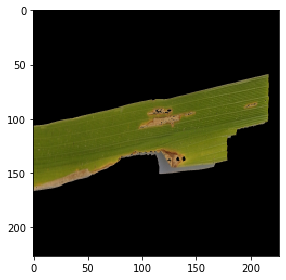

In [21]:
#Preprocessing (otsu_thresholding, BGR to RGB and resizing)

for category in SMOL_CTGR:
    count = 1
    path = os.path.join(SMOLDATADIR, category)
    for img in os.listdir(path):
        #Create Filenames for preprocessed images
        filename = category + str(count) + ".png"
        print(filename)
        count+=1
        #Loading image from directory
        some_img = imread(os.path.join(path,img))
        
        
        gray_img = rgb2gray(some_img)
        
        
        thresh = threshold_otsu(gray_img)
        thresh_otsu = gray_img < thresh
        
        filtered = masked_image(some_img, thresh_otsu)
        resize_img = cv2.resize(filtered, (227,227), interpolation = cv2.INTER_AREA)
#         rgb_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
        imshow(resize_img)
        break
    break
#         cv2.imwrite(filename, rgb_img)

In [5]:
def Canny_detector(img, weak_th = None, strong_th = None):
      
    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
       
    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
      
    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
       
    # setting the minimum and maximum thresholds 
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
       
       
    # finally returning the magnitude of
    # gradients of edges
    return mag

In [6]:
def rgb_splitter(image):
    rgb_list = ['Reds','Greens','Blues']
    fig, ax = plt.subplots(1, 3, figsize=(8,8), sharey = True)
    for i in range(3):
        ax[i].imshow(image[:,:,i], cmap = rgb_list[i])
        ax[i].set_title(rgb_list[i], fontsize = 15)
        
def autocrop_image(img, border = 0):
    image = Image.fromarray(img)
    bbox = image.getbbox()
    image = image.crop(bbox)
    (width, height) = image.size

    width += border * 2
    height += border * 2
    
    cropped_image = Image.new("RGBA", (width, height), (0,0,0,0))
    cropped_image.paste(image, (border, border))

    return np.array(cropped_image)

In [ ]:
#Testing different proprocessing methods
for category in CATEGORIES:
    path = os.path.join(ORIGCROPDATADIR, category)
    print(path)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image_file = Image.open(img_path)
        
#         image_file.save(img, quality = 95)
       
        img_array = cv2.imread(os.path.join(path,img))
        resize_img = cv2.resize(img_array, (227,227), interpolation = cv2.INTER_AREA)
        canny_img = Canny_detector(resize_img)
        
        clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (8,8))
        
        lab = cv2.cvtColor(resize_img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        l2 = clahe.apply(l)
        
        lab = cv2.merge((l2,a,b))
        
        enc_img1 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        
#         test_img_new = enc_img * [0,1,0] #Only color is green [R,G,B]
        test_img_new = cv2.cvtColor(enc_img1, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(test_img_new)
        
        l2 = clahe.apply(l)
        
        lab = cv2.merge((l2,a,b))
        
        enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        
        test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(test_img_new)
        
        l2 = clahe.apply(l)
        
        lab = cv2.merge((l2,a,b))
        
        test_img_new = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        kernel = np.array([[0, -1, 0],
                           [-1, 5,-1],
                           [0, -1, 0]])
        sharp_img = cv2.filter2D(enc_img, ddepth = -1, kernel = kernel)
#         sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB)
#         cv2.imwrite('test.jpeg', enc_img)
        RBG_img1 = cv2.cvtColor(resize_img, cv2.IMREAD_GRAYSCALE)
        RBG_img1 = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
        _, segmented1 = cv2.threshold(RBG_img1, 127, 255, cv2.THRESH_BINARY)
        RBG_img2 = cv2.cvtColor(segmented1, cv2.COLOR_BGR2RGB)
        
        #Visualization of original to enhanced to 
        fig, ax = plt.subplots(1,3, figsize =(10,10))
        
        
        ax[0].imshow(RBG_img1)
        ax[0].set_title("Original")
        ax[0].set_xlabel(category)
        
        ax[1].imshow(enc_img1)
        ax[1].set_title("Enchanced (Contrast)")
        ax[1].set_xlabel(category)
        
        ax[2].imshow(sharp_img)
        ax[2].set_title("Test Image")
        ax[2].set_xlabel(category)
        
        
        rgb_splitter(sharp_img)
        break

In [ ]:
#Visualize images in training dataset
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Training Data
for index in range(10):   
    ax = axes[index//5, index%5]
    ax.imshow(X_train[index])
    ax.set_title(classes[y_train[index]]) 
plt.tight_layout()
plt.show()

In [ ]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [ ]:
#Shows images from CROPDATADIR file path
for category in CATEGORIES:
    path = os.path.join(CROPDATADIR, category)
    print(path)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image_file = Image.open(img_path)
        
#         image_file.save(img, quality = 95)
        
        img_array = cv2.imread(os.path.join(path,img))
        
        
        RBG_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        zoom1 = clipped_zoom(RBG_img, 2)
        zoom2 = clipped_zoom(RBG_img, 3)
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(image_file)
        ax[1].imshow(zoom1)
        ax[2].imshow(zoom2)
        break
    break

In [ ]:
#DONT RUN THIS ANYMORE, WITHOUT CHANGING THE PATH OF THE FILENAME!!!!!!!!!!!!!!!!!!!!
#ORIGINAL CROPPED DATASET IS IN NEW FOLDER!!!!!!!
# #Adding augmentation then adding to dataset (Di pa na aadd ung augmented images sa dataset)
# for category in CATEGORIES:
#     count = 1
#     path = os.path.join(CROPDATADIR, category)
#     print(path)
#     for img in os.listdir(path):
#         filename_90 = path + "\\" + category + str(count) + "_90" + ".png"
#         filename_180 = path + "\\" + category + str(count) + "_180" + ".png"
#         filename_270 = path + "\\" + category + str(count) + "_270" + ".png"
#         img_array = cv2.imread(os.path.join(path,img))
#         RBG_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
#         rotate_90_img = cv2.rotate(img_array, cv2.cv2.ROTATE_90_CLOCKWISE)
#         rotate_270_img = cv2.rotate(img_array, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
#         rotate_180_img = cv2.rotate(img_array, cv2.ROTATE_180)
#         fig, ax = plt.subplots(1,4,figsize = (12,6))
#         count+=1
# #         ax[0].imshow(RBG_img)
# #         ax[0].set_title("Original")
        
# #         ax[1].imshow(rotate_90_img)
# #         ax[1].set_title("Rotated - 90 degrees")
        
#         cv2.imwrite(filename_90, rotate_90_img)
        
# #         ax[2].imshow(rotate_180_img)
# #         ax[2].set_title("Rotated - 180 degrees")
        
#         cv2.imwrite(filename_180, rotate_180_img)
        
# #         ax[3].imshow(rotate_270_img)
# #         ax[3].set_title("Rotated - 270 degrees")
        
#         cv2.imwrite(filename_270, rotate_270_img)
# #         break
# #     break

In [ ]:
#Build the actual TRAINING DATASET
training_data = []

def create_training_data():
    for i in range(len(CATEGORIES)):
        category = CATEGORIES[i]
        path = os.path.join(ORIGCROPDATADIR, category)
        for img in os.listdir(path):
            img_path = os.path.join(path,img)
            image_file = Image.open(img_path)

#             image_file.save(img, quality = 95)
            
            img_array = cv2.imread(os.path.join(path,img))
            clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (8,8))
            
            resize_img = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
            lab = cv2.cvtColor(resize_img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))

            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    #         test_img_new = enc_img * [0,1,0] #Only color is green [R,G,B]
            test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
            l,a,b = cv2.split(test_img_new)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))

            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

#             test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
#             l,a,b = cv2.split(test_img_new)

#             l2 = clahe.apply(l)

#             lab = cv2.merge((l2,a,b))

#             test_img_new = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            kernel = np.array([[0, -1, 0],
                               [-1, 5.35,-1],
                               [0, -1, 0]])
            sharp_img = cv2.filter2D(enc_img, ddepth = -1, kernel = kernel)

#             RBG_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            blur_img = cv2.GaussianBlur(enc_img, (7,7), 0)
            plt.imshow(blur_img)
            
            training_data.append([blur_img,i])
            print(CATEGORIES[i])
#             break
#         break
create_training_data()

Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease


Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease
Disease


Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy
Healthy


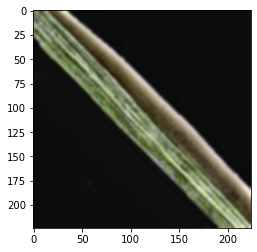

In [7]:
#Build the actual TRAINING DATASET on TWO Classes (Disease, Healthy)
training_data = []

def create_training_data():
    for i in range(len(TWO_CTGR)):
        category = TWO_CTGR[i]
        path = os.path.join(NEWDATADIR, category)
        for img in os.listdir(path):
            img_path = os.path.join(path,img)
            image_file = Image.open(img_path)

#             image_file.save(img, quality = 95)
            
            img_array = cv2.imread(os.path.join(path,img))
        
            resize_img = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
        
        
            gray_img = rgb2gray(resize_img)


            thresh = threshold_otsu(gray_img)
            thresh_otsu = gray_img < thresh

            filtered = masked_image(resize_img, thresh_otsu)
            
            clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (8,8))
            
            
            lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))

            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    #         test_img_new = enc_img * [0,1,0] #Only color is green [R,G,B]
            test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
            l,a,b = cv2.split(test_img_new)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))

            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            enc_img = cv2.cvtColor(enc_img, cv2.COLOR_BGR2RGB)
#             test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
#             l,a,b = cv2.split(test_img_new)

#             l2 = clahe.apply(l)

#             lab = cv2.merge((l2,a,b))

#             test_img_new = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            kernel = np.array([[0, -1, 0],
                               [-1, 5,-1],
                               [0, -1, 0]])
            sharp_img = cv2.filter2D(enc_img, ddepth = -1, kernel = kernel)

#             RBG_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            blur_img = cv2.GaussianBlur(sharp_img, (7,7), 0)
            plt.imshow(blur_img)
            
            training_data.append([blur_img,i])
            print(TWO_CTGR[i])
create_training_data()

In [ ]:
#Counting no. of images per class
count_brown = 0
count_healthy = 0
count_hispa = 0
count_leafblast = 0
for image in training_data:
    if image[1] == 0:
        count_brown += 1
    elif image[1] == 1:
        count_healthy += 1
    elif image[1] == 2:
        count_hispa += 1
    elif image[1] == 3:
        count_leafblast += 1
print('BrownSpots: ', count_brown)
print('Healthy: ', count_healthy)
print('Hispa: ', count_hispa)
print('LeafBlast: ', count_leafblast)

In [ ]:
random.shuffle(training_data)

In [52]:
#Separation of images from their respective labels/classes
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, 224,224,3)
print(len(X))
print(len(y))
print(X.shape)
y[:10]

1764
1764
528
528
(1764, 224, 224, 3)
(528, 224, 224, 3)
[2, 0, 0, 1, 2, 1, 2, 1, 0, 2]
[2, 0, 0, 1, 2, 1, 2, 1, 0, 2]


In [ ]:
#Turn x(images), and y(labels) arrays to pickle files
pickle_out = open('pickles\\X_cropped_lab2_blur_two_classes.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('pickles\\y_cropped_lab2_blur_two_classes.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()


# Generate Dataset based on 3 classes

In [28]:
#Build the actual TRAINING DATASET on THREE Classes (Bacterial leaf blight, Brown spot, Leaf smut)
training_data = []
blight_data = []
brown_data = []
smut_data = []
def create_training_data():
    for i in range(len(SMOL_CTGR)):
        category = SMOL_CTGR[i]
        path = os.path.join(SMOLDATADIR, category)
        for img in os.listdir(path):
            img_path = os.path.join(path,img)
            image_file = Image.open(img_path)

#             image_file.save(img, quality = 95)
            
            img_array = cv2.imread(os.path.join(path,img))
        
            resize_img = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
        
        
            gray_img = rgb2gray(resize_img)


            thresh = threshold_otsu(gray_img)
            thresh_otsu = gray_img < thresh
            
            if (img == "blacked1" or img == "blacked2") and category == "Leaf smut":
                filtered = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
                lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
            else:
                filtered = masked_image(resize_img, thresh_otsu)
                filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)
                lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
            
            
            
            
            
            clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (8,8))
            
            
            
            l, a, b = cv2.split(lab)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))
            
            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    #         test_img_new = enc_img * [0,1,0] #Only color is green [R,G,B]
            test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
            l,a,b = cv2.split(test_img_new)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))

            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            
            rotate_90_img_enc = cv2.rotate(enc_img, cv2.cv2.ROTATE_90_CLOCKWISE)
            rotate_270_img_enc = cv2.rotate(enc_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotate_180_img_enc = cv2.rotate(enc_img, cv2.ROTATE_180)
            
            flip_x_enc = cv2.flip(enc_img, 0)
            flip_y_enc = cv2.flip(enc_img, 1)
            flip_xy_enc = cv2.flip(enc_img, -1)
#             test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
#             l,a,b = cv2.split(test_img_new)

#             l2 = clahe.apply(l)

#             lab = cv2.merge((l2,a,b))

#             test_img_new = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            kernel = np.array([[0, -1, 0],
                               [-1, 4.9,-1],
                               [0, -1, 0]])
            sharp_img = cv2.filter2D(enc_img, ddepth = -1, kernel = kernel)
        
            rotate_90_img_sharp = cv2.rotate(sharp_img, cv2.cv2.ROTATE_90_CLOCKWISE)
            rotate_270_img_sharp = cv2.rotate(sharp_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotate_180_img_sharp = cv2.rotate(sharp_img, cv2.ROTATE_180)
            
            flip_x_sharp = cv2.flip(sharp_img, 0)
            flip_y_sharp = cv2.flip(sharp_img, 1)
            flip_xy_sharp = cv2.flip(sharp_img, -1)
#             RBG_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            blur_img = cv2.GaussianBlur(sharp_img, (7,7), 0)
    
            rotate_90_img_blur = cv2.rotate(blur_img, cv2.cv2.ROTATE_90_CLOCKWISE)
            rotate_270_img_blur = cv2.rotate(blur_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotate_180_img_blur = cv2.rotate(blur_img, cv2.ROTATE_180)
            
            flip_x_blur = cv2.flip(blur_img, 0)
            flip_y_blur = cv2.flip(blur_img, 1)
            flip_xy_blur = cv2.flip(blur_img, -1)
            
            if category == "Bacterial leaf blight":
                blight_data.append([sharp_img,i])
                blight_data.append([rotate_90_img_sharp,i])
                blight_data.append([rotate_180_img_sharp,i])
                blight_data.append([rotate_270_img_sharp,i])
                blight_data.append([flip_x_sharp,i])
                blight_data.append([flip_y_sharp,i])
                blight_data.append([flip_xy_sharp,i])

                blight_data.append([enc_img,i])
                blight_data.append([rotate_90_img_enc,i])
                blight_data.append([rotate_180_img_enc,i])
                blight_data.append([rotate_270_img_enc,i])
                blight_data.append([flip_x_enc,i])
                blight_data.append([flip_y_enc,i])
                blight_data.append([flip_xy_enc,i])

                blight_data.append([blur_img,i])
                blight_data.append([rotate_90_img_blur,i])
                blight_data.append([rotate_180_img_blur,i])
                blight_data.append([rotate_270_img_blur,i])
                blight_data.append([flip_x_blur,i])
                blight_data.append([flip_y_blur,i])
                blight_data.append([flip_xy_blur,i])
            elif category == "Brown spot":
                brown_data.append([sharp_img,i])
                brown_data.append([rotate_90_img_sharp,i])
                brown_data.append([rotate_180_img_sharp,i])
                brown_data.append([rotate_270_img_sharp,i])
                brown_data.append([flip_x_sharp,i])
                brown_data.append([flip_y_sharp,i])
                brown_data.append([flip_xy_sharp,i])

                brown_data.append([enc_img,i])
                brown_data.append([rotate_90_img_enc,i])
                brown_data.append([rotate_180_img_enc,i])
                brown_data.append([rotate_270_img_enc,i])
                brown_data.append([flip_x_enc,i])
                brown_data.append([flip_y_enc,i])
                brown_data.append([flip_xy_enc,i])

                brown_data.append([blur_img,i])
                brown_data.append([rotate_90_img_blur,i])
                brown_data.append([rotate_180_img_blur,i])
                brown_data.append([rotate_270_img_blur,i])
                brown_data.append([flip_x_blur,i])
                brown_data.append([flip_y_blur,i])
                brown_data.append([flip_xy_blur,i])
            elif category == "Leaf smut":
                smut_data.append([sharp_img,i])
                smut_data.append([rotate_90_img_sharp,i])
                smut_data.append([rotate_180_img_sharp,i])
                smut_data.append([rotate_270_img_sharp,i])
                smut_data.append([flip_x_sharp,i])
                smut_data.append([flip_y_sharp,i])
                smut_data.append([flip_xy_sharp,i])

                smut_data.append([enc_img,i])
                smut_data.append([rotate_90_img_enc,i])
                smut_data.append([rotate_180_img_enc,i])
                smut_data.append([rotate_270_img_enc,i])
                smut_data.append([flip_x_enc,i])
                smut_data.append([flip_y_enc,i])
                smut_data.append([flip_xy_enc,i])

                smut_data.append([blur_img,i])
                smut_data.append([rotate_90_img_blur,i])
                smut_data.append([rotate_180_img_blur,i])
                smut_data.append([rotate_270_img_blur,i])
                smut_data.append([flip_x_blur,i])
                smut_data.append([flip_y_blur,i])
                smut_data.append([flip_xy_blur,i])
            
            if (img == "blacked1" or img == "blacked2") and category == "Leaf smut":
                filtered = cv2.cvtColor(resize_img, cv2.COLOR_BGR2RGB)
                lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
                plt.imshow(lab)
                
            print(SMOL_CTGR[i])
create_training_data()

Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot

In [29]:

print("Blight: ", len(blight_data), " Brown spot: " , len(brown_data) ," Smut: " , len(smut_data))


Blight:  714  Brown spot:  714  Smut:  714


In [32]:
#Important: Shuffle training_data to rearrange the dataset itself
random.shuffle(blight_data)
random.shuffle(brown_data)
random.shuffle(smut_data)

In [35]:
#For splitting to test and training for 3 classes
X = []
y = []
X_val = []
y_val = []


train_dataset = []
val_dataset = []

total = len(blight_data) + len(brown_data) +len(smut_data)
num_classes = len(SMOL_CTGR)
split = .1
num_test = round(split * total)
num_per_class = round(num_test/num_classes)

print(num_classes)
print(num_test)
print(num_per_class)

for features, label in blight_data:
    train_dataset.append([features,label])
    
for features, label in brown_data:
    train_dataset.append([features,label])
    
for features, label in smut_data:
    train_dataset.append([features,label])
    
# Uncomment to generate validation derived from train_dataset
# #Add to training dataset
# for features, label in blight_data[num_per_class+1:]:
#     train_dataset.append([features,label])
    
# for features, label in brown_data[num_per_class:]:
#     train_dataset.append([features,label])
    
# for features, label in smut_data[num_per_class:]:
#     train_dataset.append([features,label])
    
# #Add to testing dataset 
# for features, label in blight_data[:num_per_class+1]:
#     val_dataset.append([features,label])
    
# for features, label in brown_data[:num_per_class]:
#     val_dataset.append([features,label])
    
# for features, label in smut_data[:num_per_class]:
#     val_dataset.append([features,label])
    
print(len(train_dataset))
# print(len(val_dataset))
print("Total: ", total)
random.shuffle(train_dataset)
# random.shuffle(val_dataset)

for features, label in train_dataset:
    X.append(features)
    y.append(label)

# for features, label in val_dataset:
#     X_val.append(features)
#     y_val.append(label)    
X = np.array(X).reshape(-1,224,224,3)
# X_val = np.array(X_val).reshape(-1,224,224,3)

print(X.shape)
# print(X_val.shape)
print(y[:10])
# print(y_val[:10])

3
214
71
2142
Total:  2142
(2142, 224, 224, 3)
[0, 1, 1, 2, 1, 0, 1, 1, 0, 1]


In [36]:
#Turn x(images), and y(labels) arrays to pickle files
pickle_out = open('pickles\\small_dataset\\X_train_3_classes.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('pickles\\small_dataset\\y_train_3_classes.pickle', 'wb')
pickle.dump(y, pickle_out)

# pickle_out = open('pickles\\small_dataset\\X_val_3_classes.pickle', 'wb')
# pickle.dump(X_val, pickle_out)
# pickle_out.close()

# pickle_out = open('pickles\\small_dataset\\y_val_3_classes.pickle', 'wb')
# pickle.dump(y_val, pickle_out)

pickle_out.close()

# Generate Validation dataset

In [23]:
#Build the actual TRAINING DATASET on THREE Classes (Bacterial leaf blight, Brown spot, Leaf smut)
training_data = []
blight_data = []
brown_data = []
smut_data = []
def create_validating_data():
    for i in range(len(SMOL_CTGR)):
        category = SMOL_CTGR[i]
        path = os.path.join(VALSMOLDATADIR, category)
        for img in os.listdir(path):
            img_path = os.path.join(path,img)
            image_file = Image.open(img_path)

#             image_file.save(img, quality = 95)
            
            img_array = cv2.imread(os.path.join(path,img))
        
            resize_img = cv2.resize(img_array, (224,224), interpolation = cv2.INTER_AREA)
        
        
            gray_img = rgb2gray(resize_img)


            thresh = threshold_otsu(gray_img)
            thresh_otsu = gray_img < thresh

            filtered = masked_image(resize_img, thresh_otsu)
            filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)
            
            
            
            
            
            clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (8,8))
            
            
            lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))
            
            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    #         test_img_new = enc_img * [0,1,0] #Only color is green [R,G,B]
            test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
            l,a,b = cv2.split(test_img_new)

            l2 = clahe.apply(l)

            lab = cv2.merge((l2,a,b))

            enc_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            
            rotate_90_img_enc = cv2.rotate(enc_img, cv2.cv2.ROTATE_90_CLOCKWISE)
            rotate_270_img_enc = cv2.rotate(enc_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotate_180_img_enc = cv2.rotate(enc_img, cv2.ROTATE_180)
            
            flip_x_enc = cv2.flip(enc_img, 0)
            flip_y_enc = cv2.flip(enc_img, 1)
            flip_xy_enc = cv2.flip(enc_img, -1)
#             test_img_new = cv2.cvtColor(enc_img, cv2.COLOR_RGB2LAB)
#             l,a,b = cv2.split(test_img_new)

#             l2 = clahe.apply(l)

#             lab = cv2.merge((l2,a,b))

#             test_img_new = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            kernel = np.array([[0, -1, 0],
                               [-1, 4.9,-1],
                               [0, -1, 0]])
            sharp_img = cv2.filter2D(enc_img, ddepth = -1, kernel = kernel)
        
            rotate_90_img_sharp = cv2.rotate(sharp_img, cv2.cv2.ROTATE_90_CLOCKWISE)
            rotate_270_img_sharp = cv2.rotate(sharp_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotate_180_img_sharp = cv2.rotate(sharp_img, cv2.ROTATE_180)
            
            flip_x_sharp = cv2.flip(sharp_img, 0)
            flip_y_sharp = cv2.flip(sharp_img, 1)
            flip_xy_sharp = cv2.flip(sharp_img, -1)
#             RBG_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            blur_img = cv2.GaussianBlur(sharp_img, (7,7), 0)
    
            rotate_90_img_blur = cv2.rotate(blur_img, cv2.cv2.ROTATE_90_CLOCKWISE)
            rotate_270_img_blur = cv2.rotate(blur_img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotate_180_img_blur = cv2.rotate(blur_img, cv2.ROTATE_180)
            
            flip_x_blur = cv2.flip(blur_img, 0)
            flip_y_blur = cv2.flip(blur_img, 1)
            flip_xy_blur = cv2.flip(blur_img, -1)
            
            if category == "Bacterial leaf blight":
                blight_data.append([sharp_img,i])
                blight_data.append([rotate_90_img_sharp,i])
                blight_data.append([rotate_180_img_sharp,i])
                blight_data.append([rotate_270_img_sharp,i])
                blight_data.append([flip_x_sharp,i])
                blight_data.append([flip_y_sharp,i])
                blight_data.append([flip_xy_sharp,i])

                blight_data.append([enc_img,i])
                blight_data.append([rotate_90_img_enc,i])
                blight_data.append([rotate_180_img_enc,i])
                blight_data.append([rotate_270_img_enc,i])
                blight_data.append([flip_x_enc,i])
                blight_data.append([flip_y_enc,i])
                blight_data.append([flip_xy_enc,i])

                blight_data.append([blur_img,i])
                blight_data.append([rotate_90_img_blur,i])
                blight_data.append([rotate_180_img_blur,i])
                blight_data.append([rotate_270_img_blur,i])
                blight_data.append([flip_x_blur,i])
                blight_data.append([flip_y_blur,i])
                blight_data.append([flip_xy_blur,i])
            elif category == "Brown spot":
                brown_data.append([sharp_img,i])
                brown_data.append([rotate_90_img_sharp,i])
                brown_data.append([rotate_180_img_sharp,i])
                brown_data.append([rotate_270_img_sharp,i])
                brown_data.append([flip_x_sharp,i])
                brown_data.append([flip_y_sharp,i])
                brown_data.append([flip_xy_sharp,i])

                brown_data.append([enc_img,i])
                brown_data.append([rotate_90_img_enc,i])
                brown_data.append([rotate_180_img_enc,i])
                brown_data.append([rotate_270_img_enc,i])
                brown_data.append([flip_x_enc,i])
                brown_data.append([flip_y_enc,i])
                brown_data.append([flip_xy_enc,i])

                brown_data.append([blur_img,i])
                brown_data.append([rotate_90_img_blur,i])
                brown_data.append([rotate_180_img_blur,i])
                brown_data.append([rotate_270_img_blur,i])
                brown_data.append([flip_x_blur,i])
                brown_data.append([flip_y_blur,i])
                brown_data.append([flip_xy_blur,i])
            elif category == "Leaf smut":
                smut_data.append([sharp_img,i])
                smut_data.append([rotate_90_img_sharp,i])
                smut_data.append([rotate_180_img_sharp,i])
                smut_data.append([rotate_270_img_sharp,i])
                smut_data.append([flip_x_sharp,i])
                smut_data.append([flip_y_sharp,i])
                smut_data.append([flip_xy_sharp,i])

                smut_data.append([enc_img,i])
                smut_data.append([rotate_90_img_enc,i])
                smut_data.append([rotate_180_img_enc,i])
                smut_data.append([rotate_270_img_enc,i])
                smut_data.append([flip_x_enc,i])
                smut_data.append([flip_y_enc,i])
                smut_data.append([flip_xy_enc,i])

                smut_data.append([blur_img,i])
                smut_data.append([rotate_90_img_blur,i])
                smut_data.append([rotate_180_img_blur,i])
                smut_data.append([rotate_270_img_blur,i])
                smut_data.append([flip_x_blur,i])
                smut_data.append([flip_y_blur,i])
                smut_data.append([flip_xy_blur,i])
                
            print(SMOL_CTGR[i])
create_validating_data()

Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Bacterial leaf blight
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Brown spot
Leaf smut
Leaf smut
Leaf smut
Leaf smut
Leaf smut
Leaf smut


In [24]:
print("Blight: ", len(blight_data), " Brown spot: " , len(brown_data) ," Smut: " , len(smut_data))

Blight:  126  Brown spot:  126  Smut:  126


In [25]:
#Important: Shuffle training_data to rearrange the dataset itself
random.shuffle(blight_data)
random.shuffle(brown_data)
random.shuffle(smut_data)

In [26]:
#For splitting to test and training for 3 classes

X_val = []
y_val = []



val_dataset = []
total = len(blight_data) + len(brown_data) +len(smut_data)
num_classes = len(SMOL_CTGR)
split = .1
num_test = round(split * total)
num_per_class = round(num_test/num_classes)

print(num_classes)
print(num_test)
print(num_per_class)

for features, label in blight_data:
    val_dataset.append([features,label])
    
for features, label in brown_data:
    val_dataset.append([features,label])
    
for features, label in smut_data:
    val_dataset.append([features,label])
    
# for features, label in blight_data[:num_per_class+1]:
#     test_dataset.append([features,label])
    
# for features, label in brown_data[:num_per_class]:
#     test_dataset.append([features,label])
    
# for features, label in smut_data[:num_per_class]:
#     test_dataset.append([features,label])
    
print(len(val_dataset))
# print(len(test_dataset))

random.shuffle(val_dataset)
# random.shuffle(test_dataset)

for features, label in val_dataset:
    X_val.append(features)
    y_val.append(label)

# for features, label in test_dataset:
#     X_test.append(features)
#     y_test.append(label)    
X_val = np.array(X_val).reshape(-1,224,224,3)
# X_test = np.array(X_test).reshape(-1,224,224,3)

print(X_val.shape)
# print(X_test.shape)
print(y_val[:10])
# print(y_test[:10])

3
38
13
378
(378, 224, 224, 3)
[1, 1, 0, 2, 0, 2, 2, 1, 1, 0]


In [27]:
pickle_out = open('pickles\\small_dataset\\X_val_3_classes.pickle', 'wb')
pickle.dump(X_val, pickle_out)
pickle_out.close()

pickle_out = open('pickles\\small_dataset\\y_val_3_classes.pickle', 'wb')
pickle.dump(y_val, pickle_out)

pickle_out.close()

In [ ]:
segment_img = custom_segmentation()
segment_img.inferConfig(num_classes = 3, class_names = ["BrownSpot", "Healthy", "Hispa", "LeafBlasts"])
segment_img.load_model("ResNetForPlant.h5")

In [ ]:
plt.figure(figsize = (26,18))
brown_spot = plt.imread("IMG_2998.jpg")
plt.imshow(brown_spot)

In [ ]:
segment_img.segmentImage("IMG_2998.jpg",
                        show_bboxes = True,
                        extract_segmented_objects = False,
                        save_extracted_objects = False,
                        output_image_name = "IMG_2998_segmented.jpg")

In [ ]:
plt.figure(figsize = (26,18))
brown_spot = plt.imread("IMG_2998_segmented.jpg")
plt.imshow(brown_spot)